In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import t, f, norm

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures

In [3]:
from scipy.optimize import brent, fsolve, fminbound, fmin_l_bfgs_b, minimize

In [11]:
class logistic_regression:
    def __init__(self, solver = 'lbfgs', penalty = 'l2', C = 1., tol = 1e-8, max_iter=100):
        self.solver = solver
        self.penalty = penalty
        self.C = C
        self.tol = tol
        self.max_iter = max_iter

    def _sigmoid(self, beta, data):
        return 1/(1+np.exp(-data.dot(beta)))
    
    def _llf_none(self, beta, data, label, ):
        target = np.array([-1 if i ==0 else 1 for i in label.values])
        value = sum( np.log( 1/( 1+np.exp(-(target*(data.dot(beta)))) ) ) )
        return -value
    
    def _llf_l2(self, beta, data, label, ):
        target = np.array([-1 if i ==0 else 1 for i in label.values])
        value = sum( np.log( 1/( 1+np.exp(-(target*(data.dot(beta)))) ) ) )
        return -(self.C * value) + beta.dot(beta)/2

    def _irls(self, data, label, w_init, penalty, C, cnvg_tol, max_iter):
        x = data.copy()
        w = w_init.copy()
        mu = 1/(1+np.exp(-x.dot(w)))

        s = np.zeros((data.shape[0], data.shape[0]))
        np.fill_diagonal(s, [i*(1-i) for i in mu])
        cost = 0

        for n_iter in range(max_iter):
            w_0 = w
            w = np.linalg.inv( (x.T).dot(s.dot(x)) ).dot(x.T).dot( s.dot(x.dot(w)) + label.values - mu )
            if penalty == 'none':
                c = self._llf_none(w, x, label)
            elif penalty == 'l2':
                c = self._llf_l2(w, x, label)
            else:
                raise ValueError("This penalty is not supported yet.") from None

            if n_iter==0:
                cost = c
                mu = 1/(1+np.exp(-x.dot(w)))
                np.fill_diagonal(s, [i*(1-i) for i in mu])
            else:
                if (c > cost)|(c!=c)|((cost - c) < cnvg_tol):
                    w = w_0
                    break
                else:
                    cost = c
                    mu = 1/(1+np.exp(-x.dot(w)))
                    np.fill_diagonal(s, [i*(1-i) for i in mu])
            
        return w
    
    def fit(self, X, y):
        X_ = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        
        b0_init = np.log(y.mean()/(1- y.mean()))
        self.coef_ = np.array([b0_init]+[.0]*(X.shape[1]))
        
        if self.solver == 'lbfgs':
            if self.penalty == 'l2':
                coef =  minimize(self._llf_l2, x0 = self.coef_, args = (X_, y), method = 'L-BFGS-B', )['x'] #options={'gtol': 1e-3, 'disp': True}
                self.coef_ = coef.copy()
                self.log_likelihood = -self._llf_l2(coef, X_, y)
            elif self.penalty == 'none':
                coef =  minimize(self._llf_none, x0 = self.coef_, args = (X_, y), method = 'L-BFGS-B', )['x']
                self.coef_ = coef.copy()
                self.log_likelihood = -self._llf_none(coef, X_, y)
            else:
                raise ValueError("Solver lbfgs supports only 'l2' or 'none' penalties") from None
        elif self.solver == 'irls':
            coef = self._irls(X_, y, self.coef_, self.penalty, self.C, self.tol, self.max_iter)
            self.coef_ = coef.copy()
            if self.penalty=='l2':
                self.log_likelihood = -self._llf_l2(coef, X_, y)
            else:
                self.log_likelihood = -self._llf_none(coef, X_, y)
        else:
            raise ValueError("This Solver is not supported.") from None
        
        n = X.shape[0]
        p = X.shape[1]
        self.n_samples = n
        self.n_features = p
        
        #y_ = np.array([-1 if i==.0 else 1 for i in np.array(y)])
        self.deviance = -2*( ((X_.dot(self.coef_)).T).dot(y) - np.log(1+np.exp(X_.dot(self.coef_))).sum() )
        self.residuals = -2*( (X_.dot(self.coef_))*y - np.log(1+np.exp(X_.dot(self.coef_))) )
        mu = self._sigmoid(self.coef_, X_)
        S = np.zeros((X_.shape[0], X_.shape[0]))
        np.fill_diagonal(S, [i*(1-i) for i in mu])
        covar = np.linalg.inv((X_.T).dot(S.dot(X_)))
        
        self.std_error = np.sqrt(np.diag( covar ))
        self.z_values = self.coef_ / self.std_error
        self.z_pvalues = [2*(1 - norm.cdf(abs(i),)) for i in self.z_values]
    
    def predict(self, X):
        X_ = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        result = np.array([1 if i >= .5 else 0 for i in self._sigmoid(self.coef_, X_)])
        return result
    
    def predict_proba(self, X):
        X_ = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        result = np.vstack((1. - self._sigmoid(self.coef_, X_), self._sigmoid(self.coef_, X_)))
        return result.T
    
    def score(self, X, y):
        pred = self.predict(X,)
        return np.array(pred==y, dtype=int).sum() / y.size
    
    def summary(self, feature_names = None, round_decimals=3, alpha=0.05):
        '''res_min = self.residual.min()
        res_max = self.residual.max()
        res_1q = np.quantile(self.residual, .25)
        res_med = np.median(self.residual)
        res_3q = np.quantile(self.residual, .75)
        res = pd.DataFrame(np.array([res_min, res_1q, res_med, res_3q, res_max]).reshape(1,-1), columns = ['Residuals: Min', '1Q', 'Median', '3Q', 'Max'])'''
        
        ci_lower = np.round(self.coef_ - self.std_error * norm.ppf(1-alpha/2, ), round_decimals)
        ci_upper = np.round(self.coef_ + self.std_error * norm.ppf(1-alpha/2, ), round_decimals)
        if feature_names is None:
            feat_idx = ['x0(INTCP)'] + ['x{}'.format(i) for i in range(1, self.n_features+1)]
            coef = pd.DataFrame(np.array([self.coef_, self.std_error, self.z_values, np.round(self.z_pvalues, round_decimals), ci_lower, ci_upper]).T, index = feat_idx, columns= 
                               ['coef.', 'std. error', 'z_value', 'Pr(>|z|)', '{}% LWR'.format(int(100*(1-alpha))), '{}% UPR'.format(int(100*(1-alpha)))])
        else:
            feat_idx = np.insert(feature_names, 0, '(INTCP)')
            coef = pd.DataFrame(np.array([self.coef_, self.std_error, self.z_values, np.round(self.z_pvalues, round_decimals), ci_lower, ci_upper]).T, index = feat_idx, columns= 
                               ['coef.', 'std. error', 'z_value', 'Pr(>|z|)', '{}% LWR'.format(int(100*(1-alpha))), '{}% UPR'.format(int(100*(1-alpha)))])
        dev = 'Deviance: {}'.format(self.deviance)
        llf = 'Log-likelihood: {}'.format(self.log_likelihood)
        print(dev, llf, coef, sep='\n'+'='*70+'\n')

# Load data

In [5]:
data = load_breast_cancer()
X, y, feature_names,  = data['data'], 1 - data['target'], data['feature_names']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X, columns = feature_names), pd.Series(y, name='label'), test_size = .2, random_state=42)

In [7]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
import statsmodels.api as sm

In [9]:
Xs = sm.add_constant(X_train[:, -6:])
#logit = sm.Logit(y_train.values, Xs,)
logit = sm.GLM(y_train, Xs, family=sm.families.Binomial(), )
result = logit.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                  455
Model:                            GLM   Df Residuals:                      448
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -89.286
Date:                Sun, 29 Aug 2021   Deviance:                       178.57
Time:                        03:28:15   Pearson chi2:                 1.48e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2369      0.216     -5.728      0.0

In [12]:
lr = logistic_regression(solver = 'irls', penalty='none', C=1.)
lr.fit(X_train[:, -6:], y_train)

lr.summary()

Deviance: 178.57147746625196
Log-likelihood: -89.28573873312577
              coef.  std. error   z_value  Pr(>|z|)  95% LWR  95% UPR
x0(INTCP) -1.236908    0.215952 -5.727696     0.000   -1.660   -0.814
x1         0.269614    0.288392  0.934889     0.350   -0.296    0.835
x2         0.235429    0.561026  0.419640     0.675   -0.864    1.335
x3         0.216709    0.495205  0.437615     0.662   -0.754    1.187
x4         4.489082    0.625409  7.177829     0.000    3.263    5.715
x5         0.705100    0.280765  2.511349     0.012    0.155    1.255
x6        -1.553841    0.442719 -3.509767     0.000   -2.422   -0.686


# Train: Logistic Regression

In [68]:
model = LogisticRegression(penalty='none', C=1.2)
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print(model.score(X_test, y_test))

0.9385964912280702


C:\Users\ywkim\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


In [67]:
lr = logistic_regression(solver = 'lbfgs', penalty='none', C=1.)
lr.fit(X_train, y_train)

pred_ = lr.predict(X_test)
pred_proba_ = lr.predict_proba(X_test)

print(lr.score(X_test, y_test))

0.9385964912280702


<ipython-input-4-e5b379cbb00a>:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-data.dot(beta)))
<ipython-input-4-e5b379cbb00a>:84: RuntimeWarning: invalid value encountered in sqrt
  self.std_error = np.sqrt(np.diag( covar ))


In [85]:
lr.summary(feature_names=None)

              coef.  std. error   z_value  Pr(>|z|)  95% LWR  95% UPR
x0(INTCP) -0.364353    1.220346 -0.298565     0.765   -2.756    2.027
x1         0.408608   33.352261  0.012251     0.990  -64.961   65.778
x2         0.387773    1.069075  0.362719     0.717   -1.708    2.483
x3         0.372113   32.217706  0.011550     0.991  -62.773   63.518
x4         0.475811   15.349469  0.030999     0.975  -29.609   30.560
x5         0.055776    1.217284  0.045820     0.963   -2.330    2.442
x6        -0.552823    3.117105 -0.177351     0.859   -6.662    5.557
x7         0.818521    3.901888  0.209776     0.834   -6.829    8.466
x8         1.130821    3.217043  0.351509     0.725   -5.174    7.436
x9        -0.231590    0.774880 -0.298871     0.765   -1.750    1.287
x10       -0.051502    1.681673 -0.030625     0.976   -3.348    3.245
x11        1.283352    7.911939  0.162204     0.871  -14.224   16.790
x12       -0.191938    0.927892 -0.206854     0.836   -2.011    1.627
x13        0.619224 

In [118]:
abs(pred_proba-pred_proba_).max(axis=0)

array([0.48421098, 0.48421098])

In [105]:
np.alltrue(pred==pred_)

True

In [85]:
from scipy.stats import pearsonr
n_feat = X_train.shape[1]
ll = [np.exp((beta_lbfgs[1:]*X_test[n_samp, :n_feat]).sum()  + beta_lbfgs[0]) / (1+np.exp((beta_lbfgs[1:]*X_test[n_samp, :n_feat]).sum()  + beta_lbfgs[0])) for n_samp in range(X_test.shape[0])]
pearsonr(ll, pred_proba[:,1])

(0.9999845393851949, 2.1407135880861552e-254)

In [194]:
from scipy.stats import pearsonr
n_feat = X_train.shape[1]
ll = [np.exp((beta0[1:]*X_test[n_samp, :n_feat]).sum()  + beta0[0]) / (1+np.exp((beta0[1:]*X_test[n_samp, :n_feat]).sum()  + beta0[0])) for n_samp in range(X_test.shape[0])]
pearsonr(ll, pred_proba[:,1])

(0.9644632047191988, 1.4172010046049443e-66)

In [86]:
threshold = .5
ll1 = [1 if i >=threshold else 0 for i in ll]

In [87]:
sum(1 for i in np.array(ll1)==y_test.values if i==True)/y_test.size

0.9736842105263158

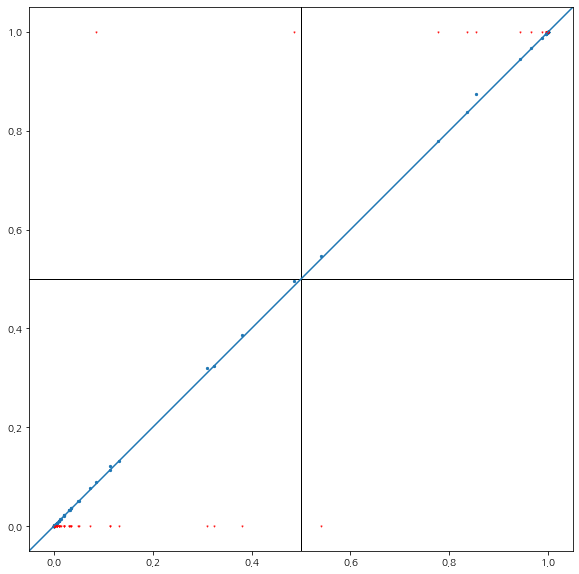

In [88]:

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1)
ax.axline((.5,0), (.5,1), color='k', linewidth=1)
ax.axline((.0,.5), (.5,.5), color='k', linewidth=1)
ax.axline((0,0), (1,1))
ax.scatter(pred_proba[:,1], ll, s=5, marker = 'o')
ax.scatter(pred_proba[:,1], y_test.values, s=1, marker = 'v', color='r')
plt.show()

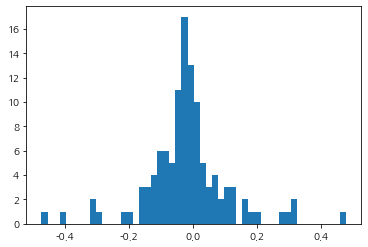

In [198]:
plt.hist(pred_proba[:,1] - ll, bins=50)
plt.show()

In [482]:
model = LogisticRegression(solver='lbfgs', )
n_feat = X_train.shape[1]
model.fit(X_train[:,0:n_feat], y_train)

pred = model.predict(X_test[:,0:n_feat])
pred_proba = model.predict_proba(X_test[:,0:n_feat])

print(model.score(X_test[:,0:n_feat], y_test))

0.9736842105263158


In [286]:
np.append(model.intercept_, model.coef_.flatten())

array([-0.83038453,  1.13449565,  1.33196438,  1.70486497,  1.39460431,
        1.62601918])

In [342]:
pred_proba[3]

array([0.89918048, 0.10081952])

In [272]:
def llf_neg(b_p, b_idx, data, label):
    beta = np.append(model.intercept_, model.coef_.flatten()[:1])
    beta[b_idx] = b_p
    return -llf(beta, data, label)

In [274]:
brent(llf_neg, args=(0, X_train[:, :1], y_train.values), brack=(-2,2))

-0.6437241565018229

In [32]:
lis = list(llf([1, i], X_train[:,0:1], y_train.values) for i in np.linspace(-7,7,  100))

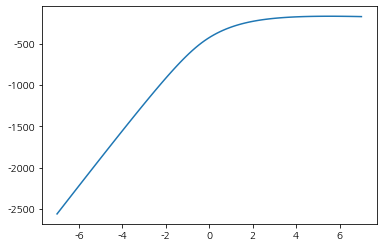

In [34]:
plt.plot(np.linspace(-7,7,  100), lis)

In [20]:
logit = (model.coef_[0]*X_train[0, 0:1]).sum() + model.intercept_[0]


In [24]:
1/(1+np.exp(-logit))

0.9518945843809761

In [27]:
X_train[0, 0:1]


array([1.0449852])

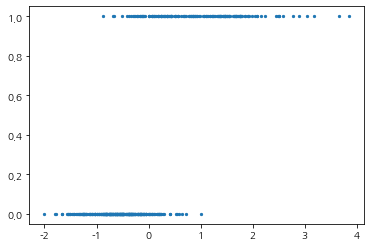

In [26]:
plt.scatter(X_train[:,:1], y_train, s=5)

In [34]:
model = LogisticRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

print(model.score(X_test, y_test))

0.9736842105263158


In [40]:
logit = (model.coef_[0]*X_test[0]).sum() + model.intercept_[0]
np.e**(logit) / (1+np.e**(logit))

0.13757253297880911

In [41]:
pred_proba[0,1]

0.13757253297880903